# Importing libs

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [130]:
import pickle
import os

if not os.path.exists('cache'):
    os.mkdir('cache')

In [131]:
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.preprocessing import MinMaxScaler

In [132]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV

In [133]:
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV

In [134]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Reading data

In [135]:
pd.set_option('display.max_columns', None)

In [136]:
X = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv')
X.set_index('building_id', inplace=True)
X.sort_index(inplace=True)

In [137]:
y = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv')
y.set_index('building_id', inplace=True)
y.sort_index(inplace=True)

In [138]:
submission_X = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Test_Values.csv')
submission_X.set_index('building_id', inplace=True)

In [139]:
frame = X.copy()
frame.insert(0, 'target', y.damage_grade)
frame.head()

,target,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,2,30,266,1224,1,25,5,2,t,r,n,f,j,s,d,0,1,0,0,0,0,0,0,0,0,0,v,0,0,0,0,0,0,0,0,0,0,0,0
8,3,17,409,12182,2,0,13,7,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
12,3,17,716,7056,2,5,12,6,o,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
16,2,4,651,105,2,80,5,4,n,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
17,2,3,1387,3909,5,40,5,10,t,r,n,f,q,o,d,0,0,0,0,1,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [140]:
submission_y = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_Submission_Format.csv')
submission_y.set_index('building_id', inplace=True)

### Information about Data

In [141]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 4 to 1052934
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-null

In [142]:
for col in X.columns:
    print('---'+col+'---')
    print(X[col].value_counts())
    print()

---geo_level_1_id---
6     24381
26    22615
10    22079
17    21813
8     19080
7     18994
20    17216
21    14889
4     14568
27    12532
13     9608
11     8220
3      7540
22     6252
25     5624
16     4332
0      4011
9      3958
12     3194
18     3189
1      2701
5      2690
30     2686
15     2320
14     1714
24     1310
23     1121
2       931
29      396
19      372
28      265
Name: geo_level_1_id, dtype: int64

---geo_level_2_id---
39      4038
158     2520
181     2080
1387    2040
157     1897
        ... 
627        1
1263       1
100        1
1123       1
319        1
Name: geo_level_2_id, Length: 1414, dtype: int64

---geo_level_3_id---
633      651
9133     647
621      530
11246    470
2005     466
        ... 
6095       1
3599       1
7886       1
9994       1
11851      1
Name: geo_level_3_id, Length: 11595, dtype: int64

---count_floors_pre_eq---
2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
9         1
8         1
Name: co

In [143]:
### Information about Data

X.info()

for col in X.columns:
    print('---'+col+'---')
    print(X[col].value_counts())
    print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 4 to 1052934
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-null

## Visualization

In [144]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,30,266,1224,1,25,5,2,t,r,n,f,j,s,d,0,1,0,0,0,0,0,0,0,0,0,v,0,0,0,0,0,0,0,0,0,0,0,0
8,17,409,12182,2,0,13,7,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
12,17,716,7056,2,5,12,6,o,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
16,4,651,105,2,80,5,4,n,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
17,3,1387,3909,5,40,5,10,t,r,n,f,q,o,d,0,0,0,0,1,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [145]:
full = pd.concat([X, y], axis = 1)

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


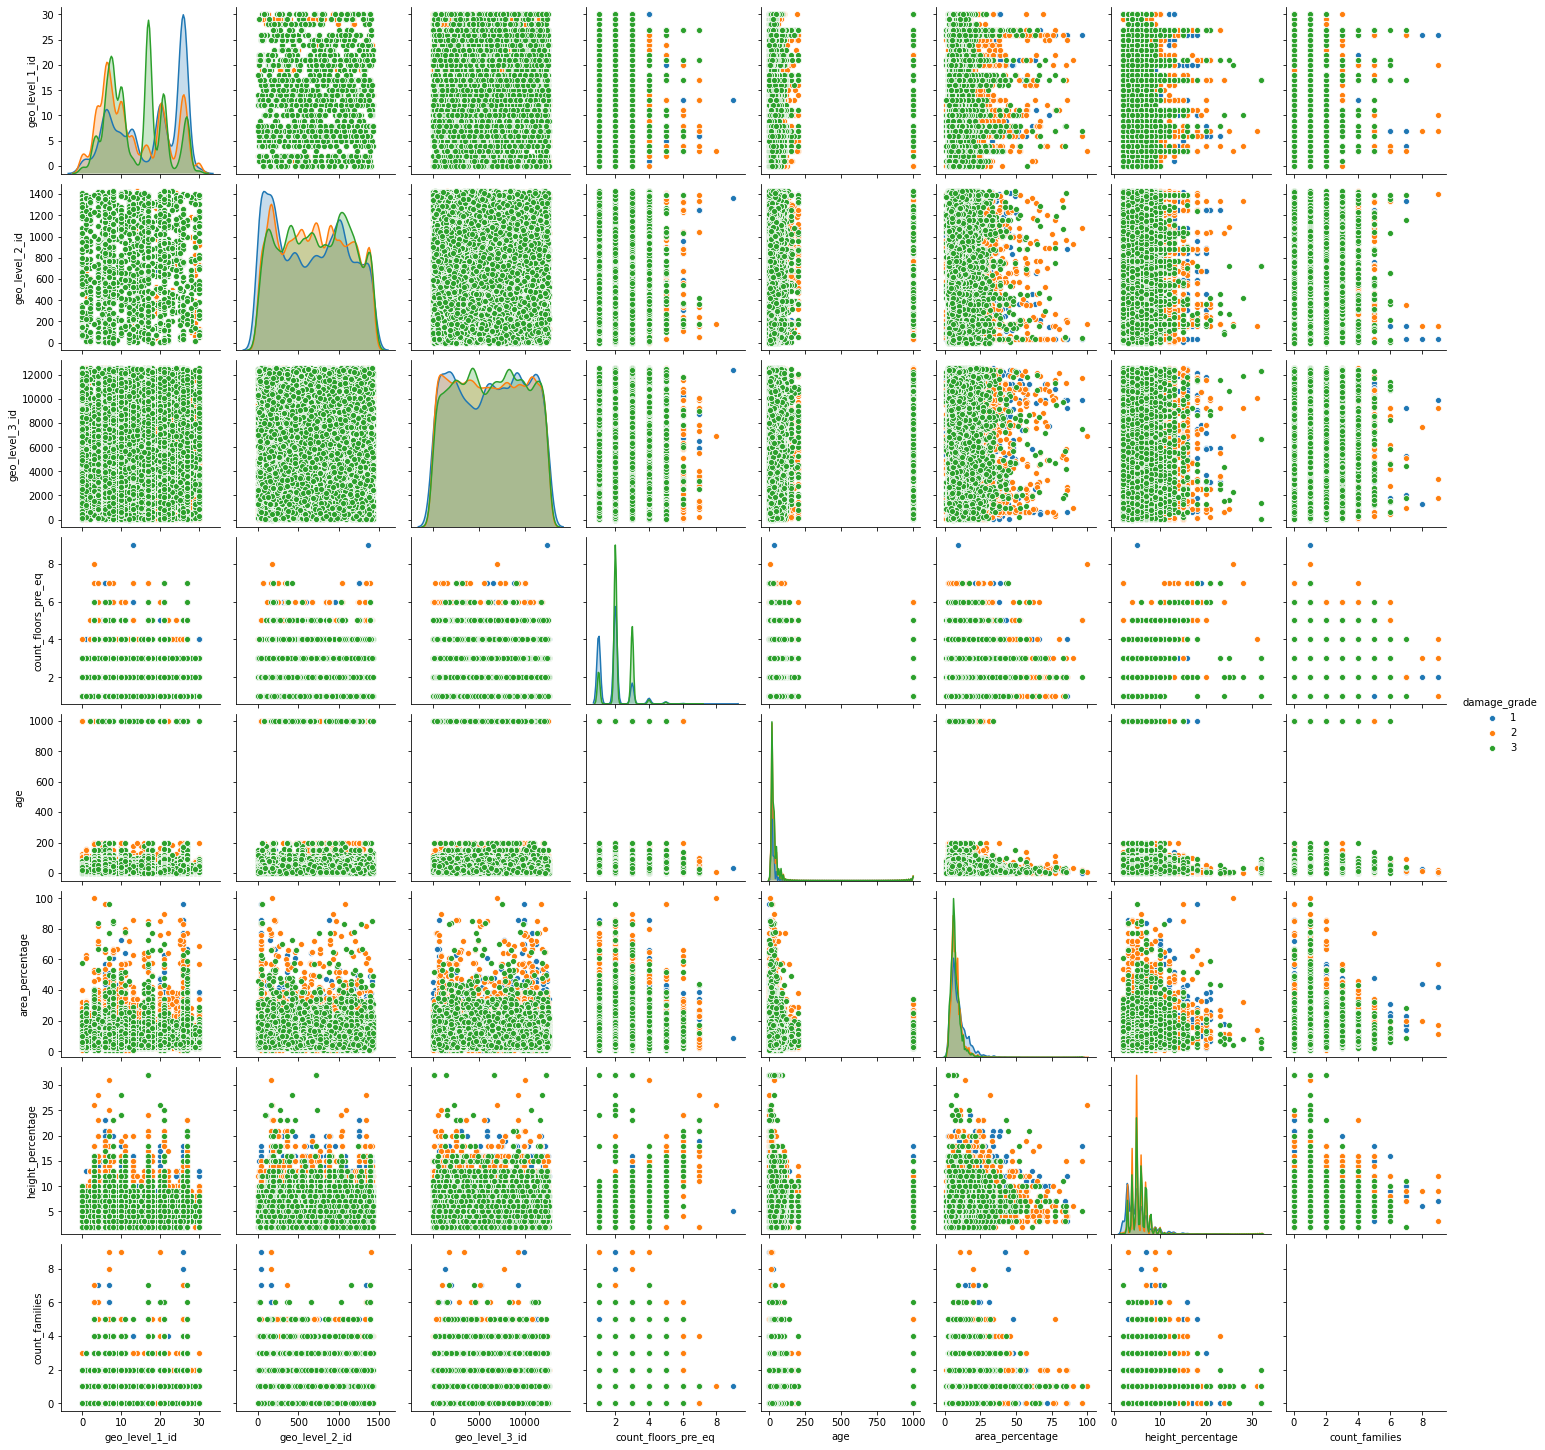

In [70]:
numerical = list(full[full.columns[full.columns.str.contains("has_") == False]].select_dtypes(include = 'int64'))
sns.pairplot(data=full[numerical], hue="damage_grade")

Text(0.5, 1.0, 'Heigh and age (age 995 excluded)')

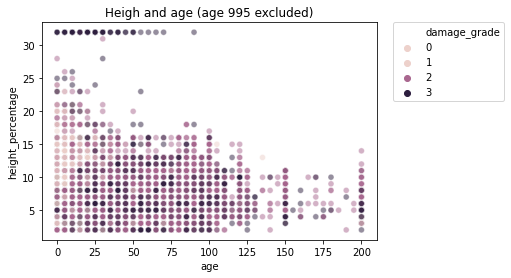

In [68]:
g = sns.scatterplot(y ='height_percentage', 
                    x = 'age', 
                    hue="damage_grade", 
                    alpha=.5, 
                    data=full[full['age'] < 500])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Heigh and age (age 995 excluded)')

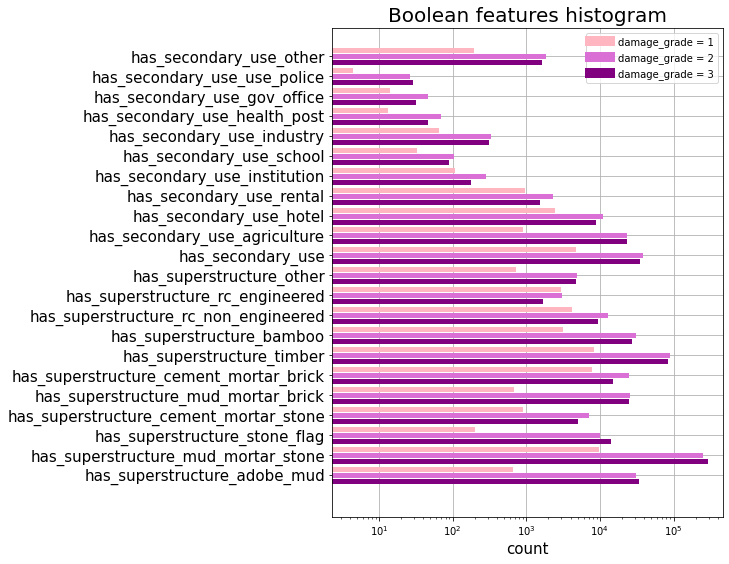

In [146]:
has = list(full.columns[full.columns.str.contains("has_")])
arr = []
fig = plt.gcf()
fig.set_size_inches(7, 9)
for el in has:
    arr.append(full[full[el] == 1]['damage_grade'].value_counts())
    #print(len(arr))
    #print(arr[-1][1])
    x = [len(arr), len(arr)]
    y = [0, arr[-1][1], arr[-1][2] + arr[-1][2], arr[-1][3] + arr[-1][2] + arr[-1][3]]
    plt.plot(y[:2], [x[0]+0.3, x[0]+0.3], color='lightpink', lw=5)
    plt.plot([y[0], y[2]], x, color='orchid', lw=5)
    plt.plot([y[0], y[3]], [x[0]-0.3, x[0]-0.3], color='purple', lw=5)
plt.xscale('log')
plt.yticks([i+1 for i in range(len(has))], has, fontsize = 15)
plt.plot([0,0], [0,0], color='lightpink', lw=10, label = 'damage_grade = 1')
plt.plot([0,0], [0,0], color='orchid', lw=10, label = 'damage_grade = 2')
plt.plot([0,0], [0,0], color='purple', lw=10, label = 'damage_grade = 3')
plt.grid()
plt.xlabel('count', fontsize = 15)
plt.title('Boolean features histogram', fontsize = 20)
plt.legend()

## Correlation

In [37]:
correlation = pd.DataFrame.corr(frame)

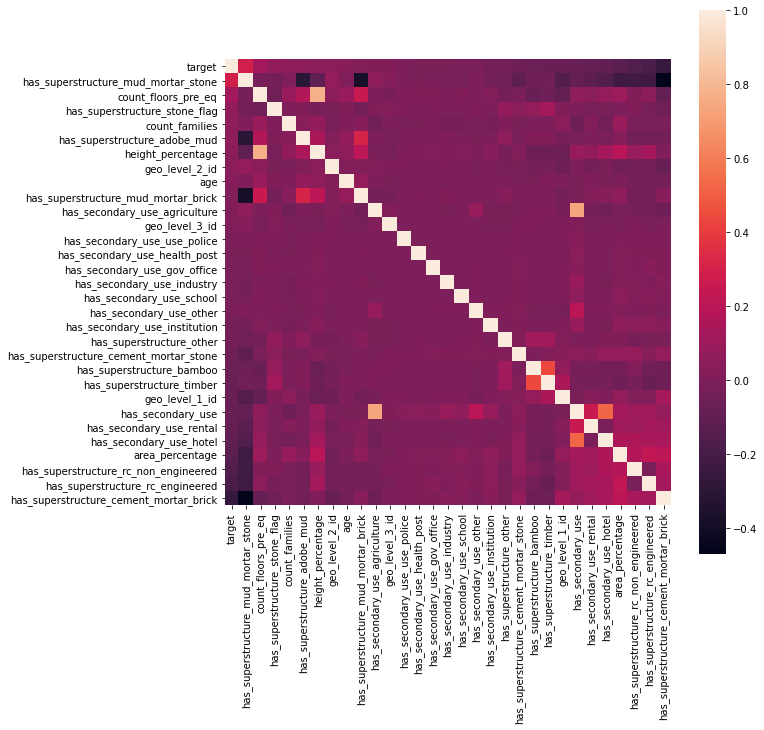

In [38]:
plt.figure(figsize = [10,10])

sorted_columns = correlation.nlargest(39, 'target').index
correlation_set = np.corrcoef(frame[sorted_columns].values.T)

heatmap = sns.heatmap(correlation_set, annot=False, square=True, yticklabels=sorted_columns.values,
                      xticklabels=sorted_columns.values)

plt.show()

### Let's see more correlated features

In [40]:
# High correlation between count_floors_pre_eq and height_percentage. Check it.

'Correlation of count_floors_pre_eq and height_percentage: {}'.format(round(pearsonr(frame['count_floors_pre_eq'],
                                                               frame['height_percentage'])[0],3))

'Correlation of count_floors_pre_eq and height_percentage: 0.773'

In [41]:
'Correlation of damage_grade and height_percentage: {}'.format(round(pearsonr(frame['target'],
                                                               frame['height_percentage'])[0],3))

'Correlation of damage_grade and height_percentage: 0.048'

In [42]:
'Correlation of damage_grade and count_floors_pre_eq: {}'.format(round(pearsonr(frame['target'],
                                                               frame['count_floors_pre_eq'])[0],3))

'Correlation of damage_grade and count_floors_pre_eq: 0.122'

# Analyzing data 

### geo_level_1_id & count_floors_pre_eq

geo_level_[2,3]_id - too concrete, we drop it.

In geo_level_1_id we leave only categories with >7500 observations.\
We see that the distributions of damage level in our geo categories are different and valuable.

In count_floors we can either drop observations with <2000 and make the feature numerical, or just make one more category from them and make it categorical feature.

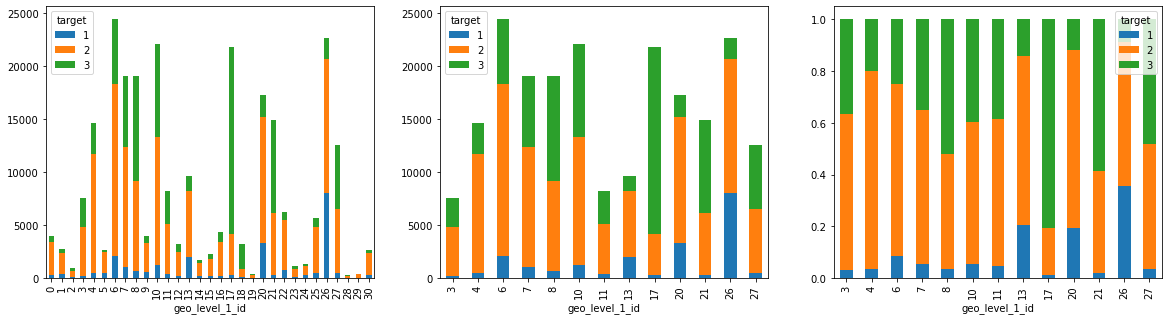

Feature: geo_level_1_id
Category list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Good categories: [3, 4, 6, 7, 8, 10, 11, 13, 17, 20, 21, 26, 27]


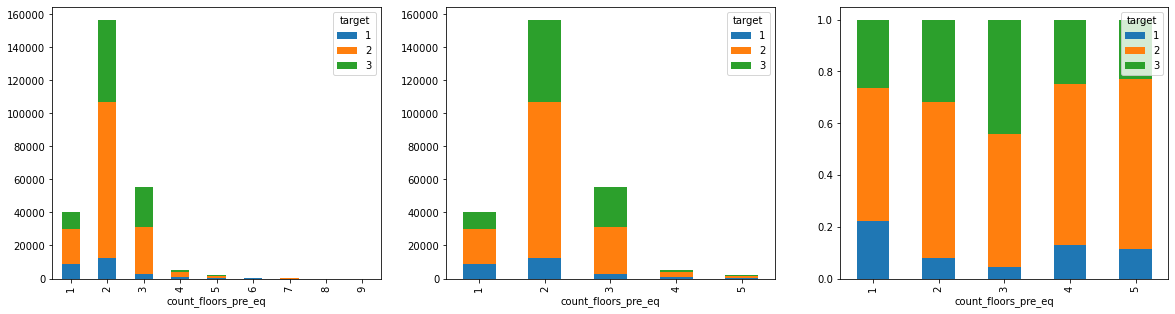

Feature: count_floors_pre_eq
Category list: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Good categories: [1, 2, 3, 4, 5]


In [29]:
def function1(frame, feature, threshold=0, upper_threshold=1e9):
    categories = sorted(frame[feature].unique())
    counts = frame.groupby(feature).target.value_counts().to_frame('counts').reset_index()
    counts = counts.pivot(feature, 'target', 'counts').fillna(0)

    good = (counts.sum(axis=1) >= threshold) & (counts.sum(axis=1) <=upper_threshold)
    counts_total = counts.sum(axis=1).values.reshape(-1, 1)

    _, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 5))
    counts.plot(kind='bar', stacked=True, ax=ax1)
    counts[good].plot(kind='bar', stacked=True, ax=ax2)
    (counts[good] / counts_total[good]).plot(kind='bar', stacked=True, ax=ax3); plt.show()

    good_list = list(good[good].index)
    print('Feature:', feature)
    print('Category list:', categories)
    print('Good categories:', good_list)
function1(frame, 'geo_level_1_id', 7500)
function1(frame, 'count_floors_pre_eq', 2000)

### Age

We drop observations with age > 100 not to overfit our model, this feature is numerical

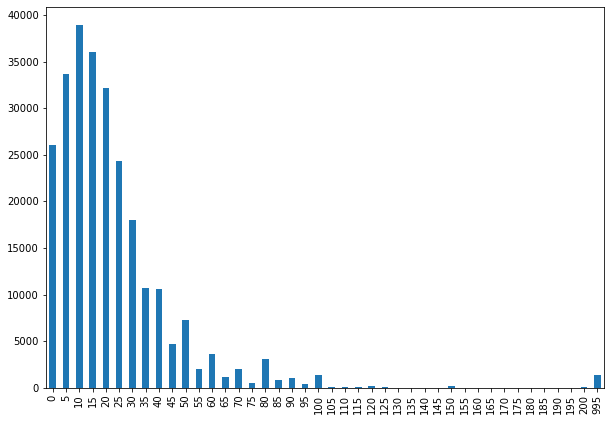

In [30]:
plt.figure(figsize = [10,7])

z = frame.age.value_counts().sort_index()
z.plot(kind='bar')

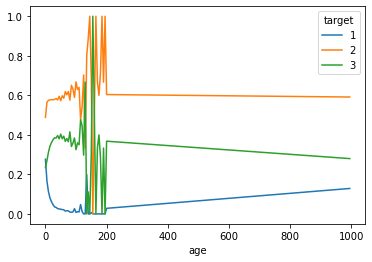

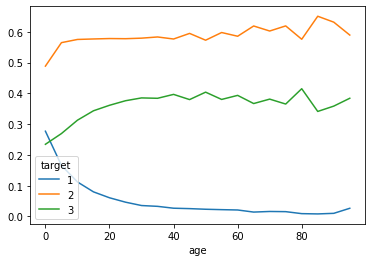

In [31]:
def function2(frame, feature, threshold=1e9):
    counts = frame[frame[feature] < threshold].groupby([feature, 'target'])\
        .target.count().to_frame('counts').reset_index()
    counts = counts.pivot(feature,'target', 'counts').fillna(0)
    counts = counts.apply(lambda x: x / x.sum(), axis=1)
    counts.plot()
function2(frame, 'age')
function2(frame, 'age', 100)

### area_percentage & height_percentage

drop observations with area > 20\
height is not valuable feature

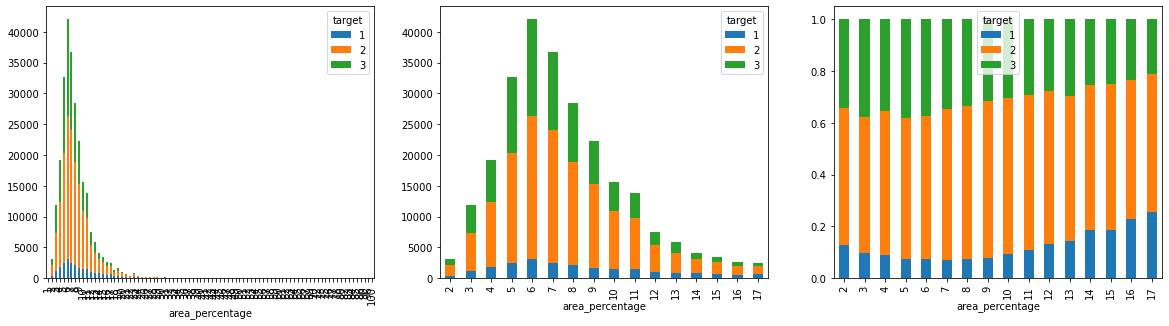

Feature: area_percentage
Category list: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 72, 73, 75, 76, 77, 78, 80, 82, 83, 84, 85, 86, 90, 96, 100]
Good categories: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


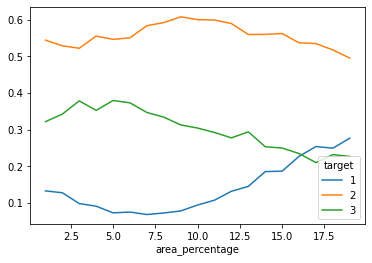

In [32]:
feature = 'area_percentage'

function1(frame, feature, 2000)
function2(frame[frame.area_percentage < 20], feature)

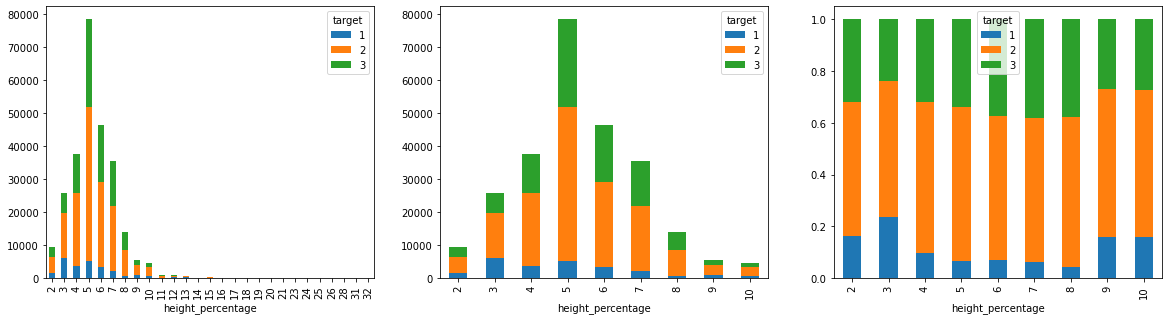

Feature: height_percentage
Category list: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 31, 32]
Good categories: [2, 3, 4, 5, 6, 7, 8, 9, 10]


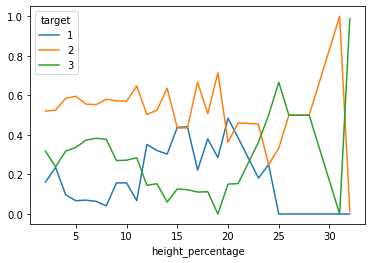

In [33]:
feature = 'height_percentage'

function1(frame, feature, 2000)
function2(frame, feature)

### land_surface_condition, foundation_type, roof_type, ground_floor_type, other_floor_type, position, plan_configuration, legal_ownership_status, count_families

land_surface_condition: drop\
foundation_type: i, r, other\
roof_type: x, other\
ground_floor_type: v, other\
other_floor_type: j, s, other\
position: drop\
plan_configuration: drop\
legal_ownership_status: a, other\
count_families: drop

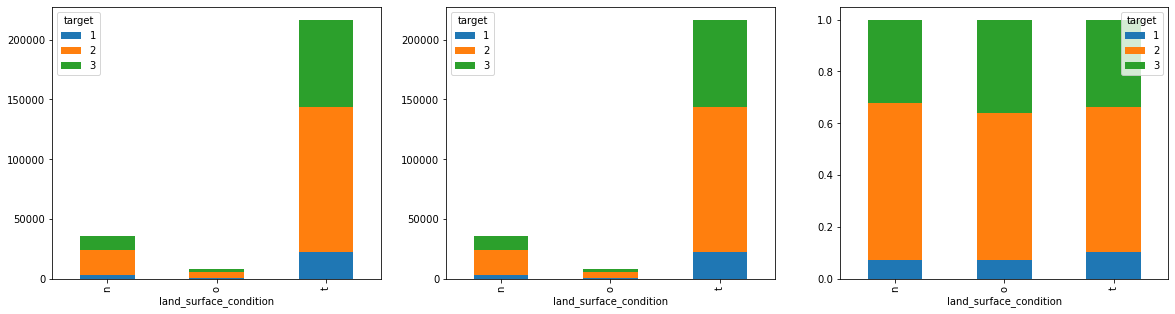

Feature: land_surface_condition
Category list: ['n', 'o', 't']
Good categories: ['n', 'o', 't']


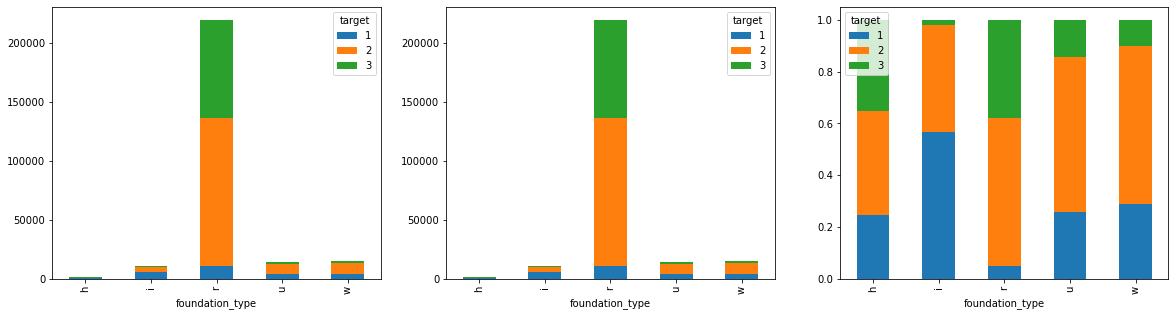

Feature: foundation_type
Category list: ['h', 'i', 'r', 'u', 'w']
Good categories: ['h', 'i', 'r', 'u', 'w']


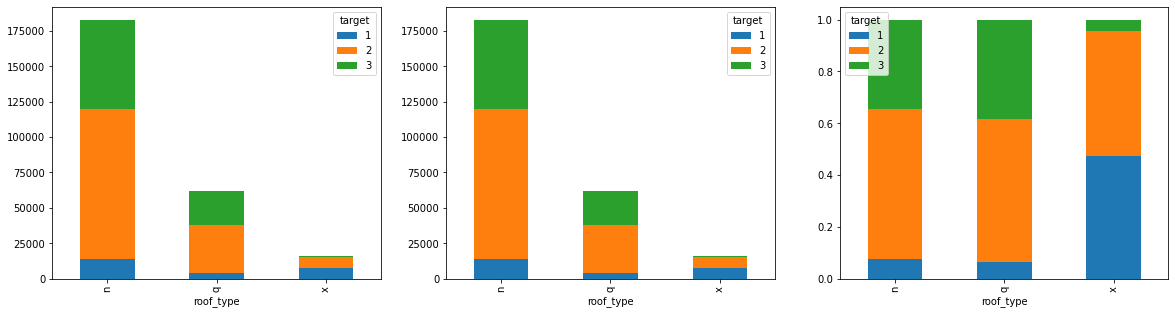

Feature: roof_type
Category list: ['n', 'q', 'x']
Good categories: ['n', 'q', 'x']


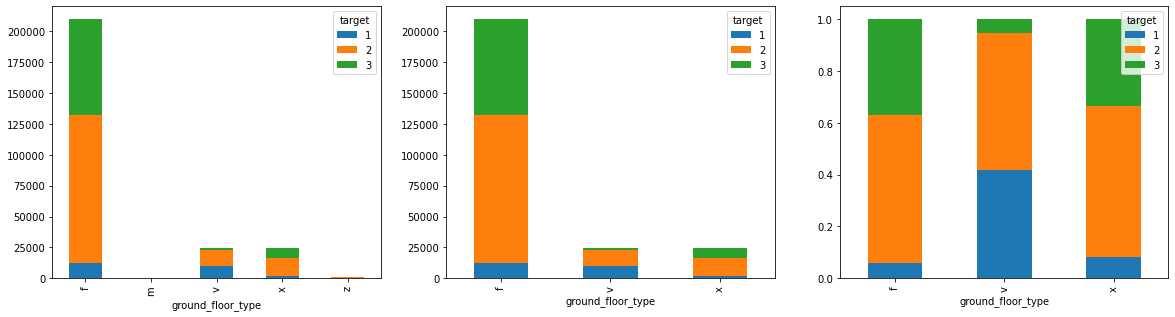

Feature: ground_floor_type
Category list: ['f', 'm', 'v', 'x', 'z']
Good categories: ['f', 'v', 'x']


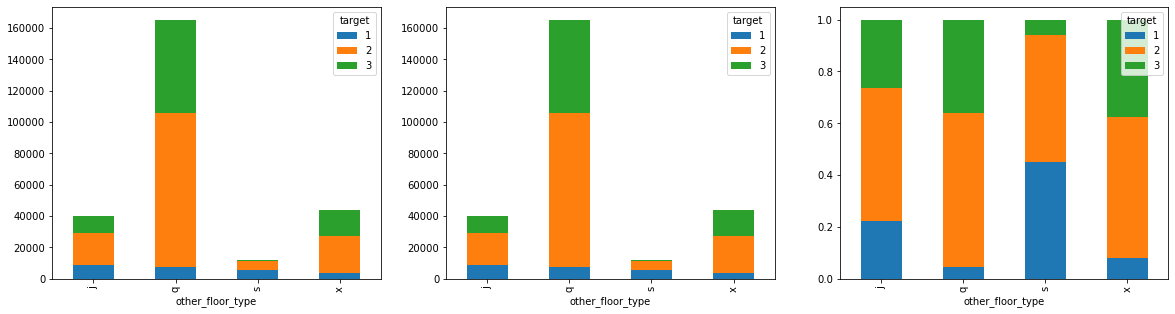

Feature: other_floor_type
Category list: ['j', 'q', 's', 'x']
Good categories: ['j', 'q', 's', 'x']


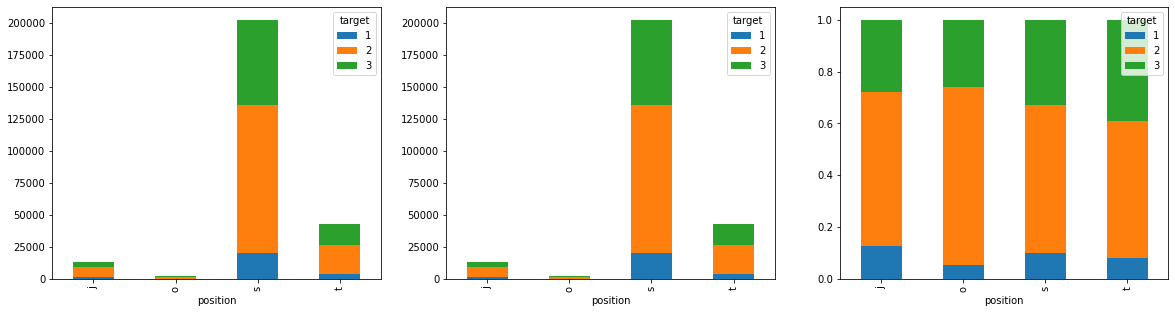

Feature: position
Category list: ['j', 'o', 's', 't']
Good categories: ['j', 'o', 's', 't']


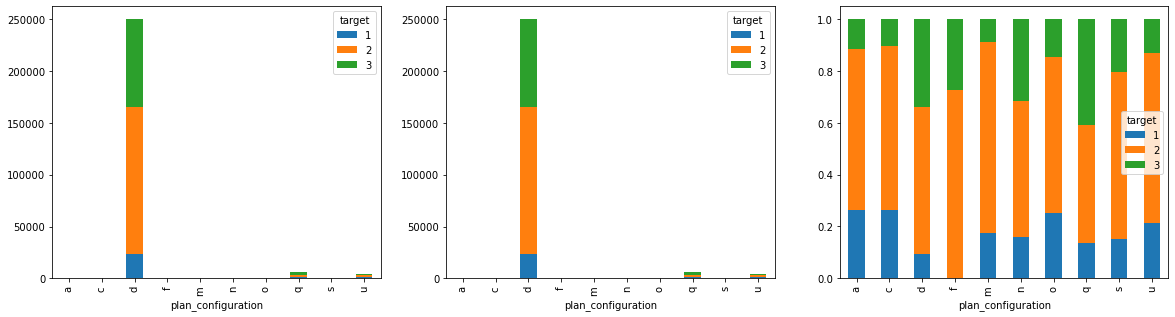

Feature: plan_configuration
Category list: ['a', 'c', 'd', 'f', 'm', 'n', 'o', 'q', 's', 'u']
Good categories: ['a', 'c', 'd', 'f', 'm', 'n', 'o', 'q', 's', 'u']


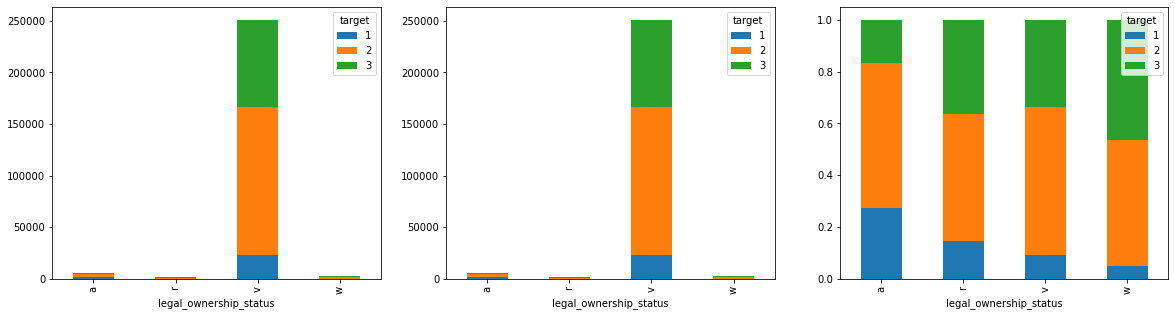

Feature: legal_ownership_status
Category list: ['a', 'r', 'v', 'w']
Good categories: ['a', 'r', 'v', 'w']


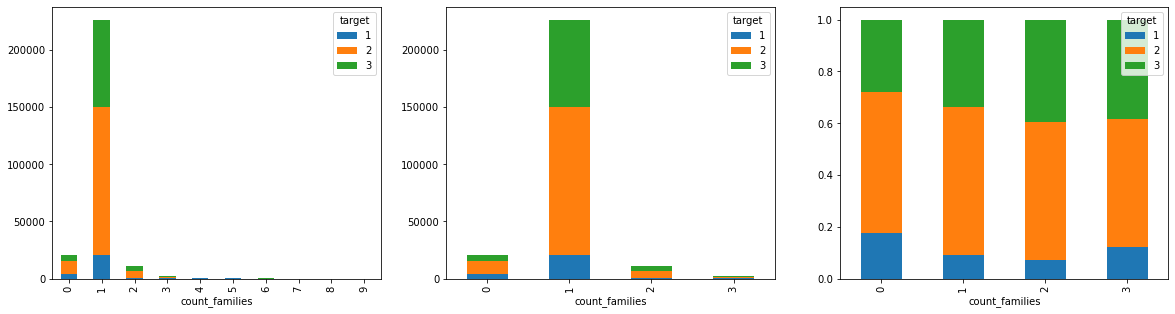

Feature: count_families
Category list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Good categories: [0, 1, 2, 3]


In [34]:
for feature, threshold in [
            ('land_surface_condition', 0),
            ('foundation_type', 0),
            ('roof_type', 0),
            ('ground_floor_type', 5000),
            ('other_floor_type', 0),
            ('position', 0),
            ('plan_configuration', 0),
            ('legal_ownership_status', 0),
            ('count_families', 1000),
        ]:
    function1(frame, feature, threshold)

### has_* features

they are all valuable

In [35]:
def function3(frame, feature, threshold=0, upper_threshold=1e9):
    counts = frame.groupby(feature).target.value_counts().to_frame('counts').reset_index()
    counts_total = counts.groupby(feature).counts.sum()
    counts.counts /= counts_total.reindex(counts[feature]).values
    _, ax = plt.subplots(1, 1, figsize=(10, 4))
    sns.barplot(data=counts, x='target', y='counts', hue=feature, ax=ax)
    plt.show()

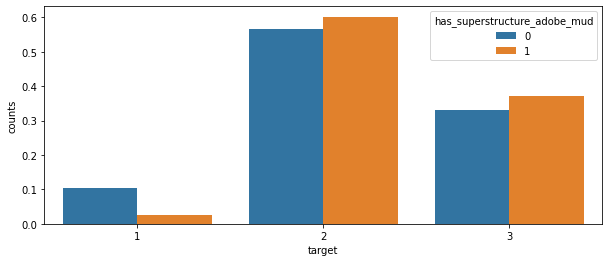

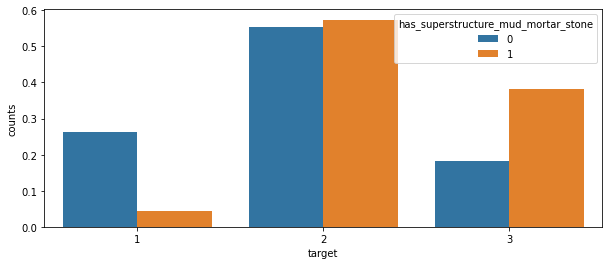

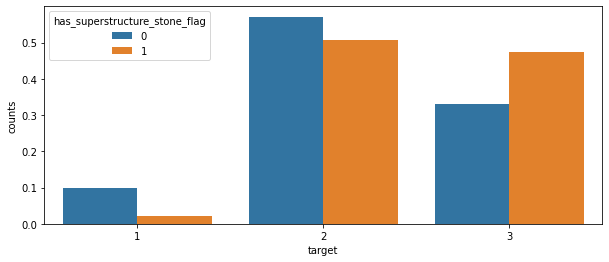

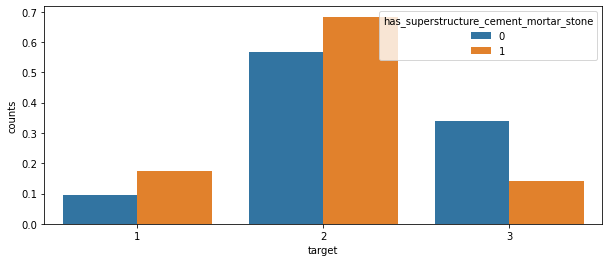

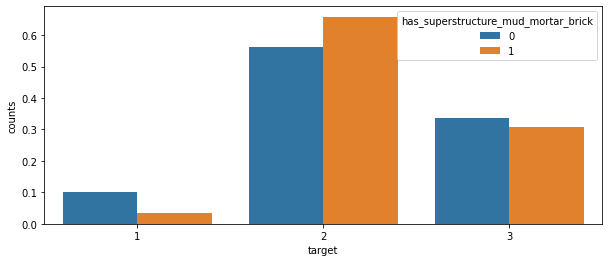

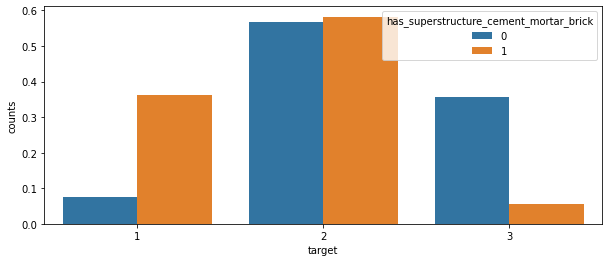

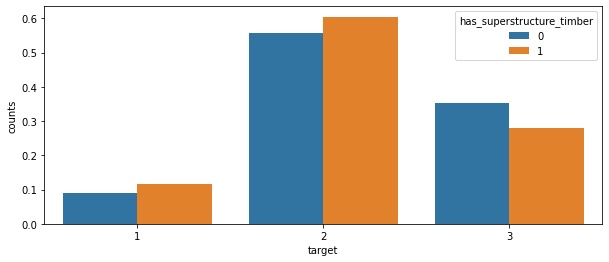

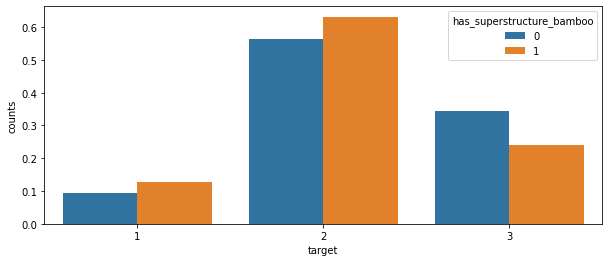

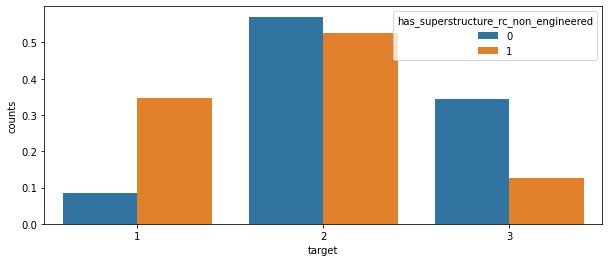

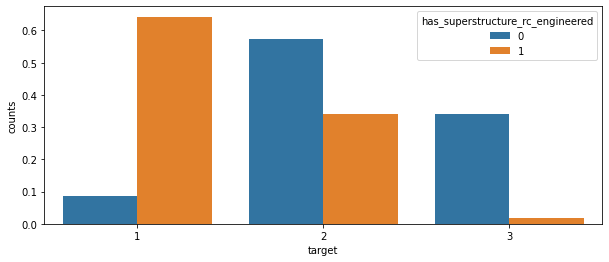

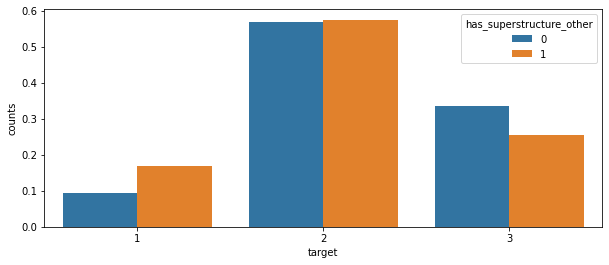

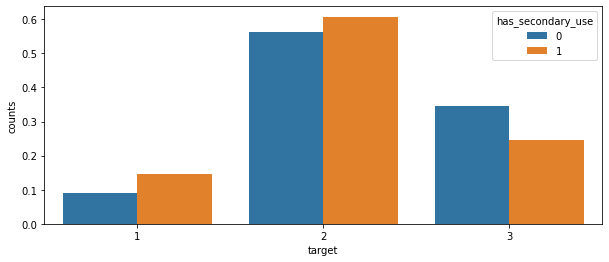

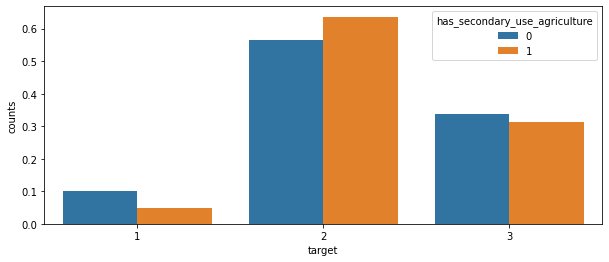

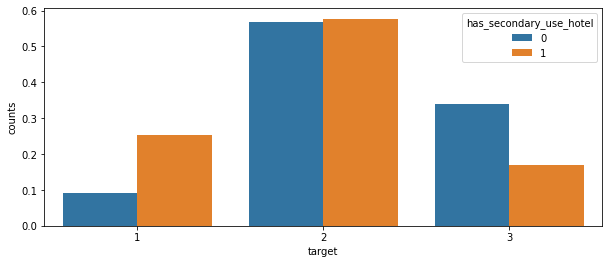

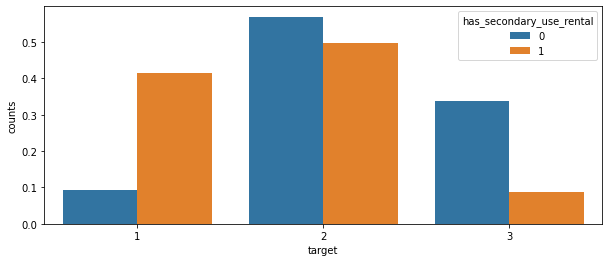

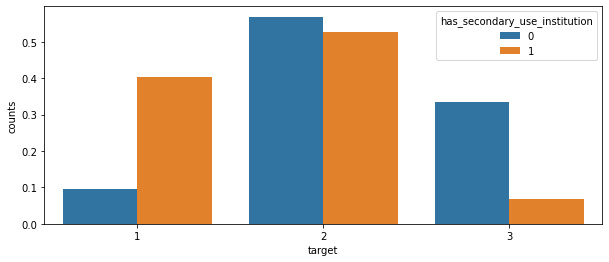

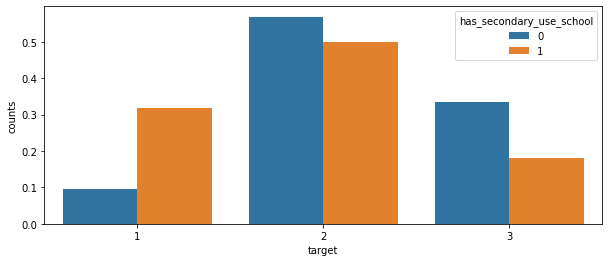

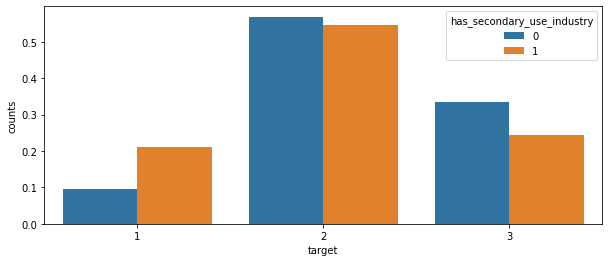

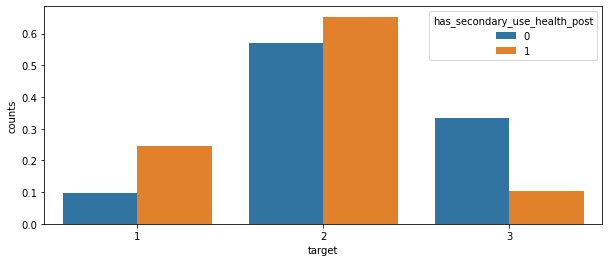

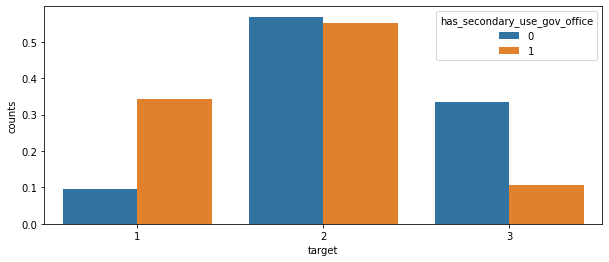

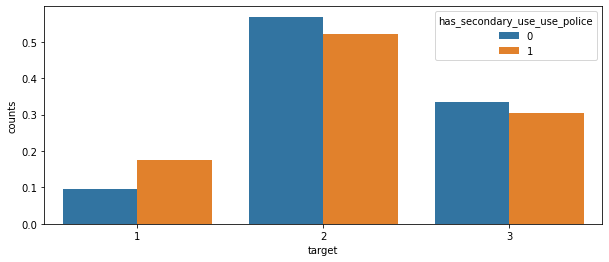

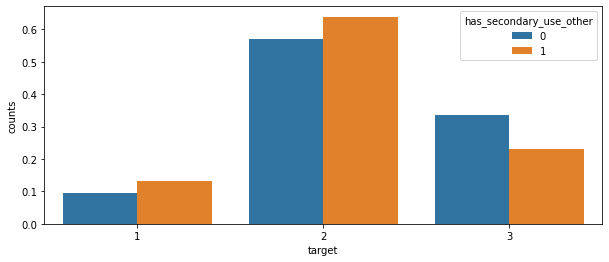

In [36]:
for feature in frame.columns:
    if feature.startswith('has_'):
        function3(frame, feature, 0)

##### So, we should drop height_percentage

# Preprocessing

### Feature selection

In [12]:
frame.drop(columns=['geo_level_2_id', 'geo_level_3_id'], inplace=True)

good_categories = set([3, 4, 6, 7, 8, 10, 11, 13, 17, 20, 21, 26, 27]) 
frame.geo_level_1_id = frame.geo_level_1_id.apply(lambda x: x if x in good_categories else None)

submission_X.drop(columns=['geo_level_2_id', 'geo_level_3_id'], inplace=True)
submission_X.geo_level_1_id = submission_X.geo_level_1_id.apply(lambda x: x if x in good_categories else None)

In [13]:
frame.count_floors_pre_eq = frame.count_floors_pre_eq.apply(lambda x: x if x <= 5 else None)

submission_X.count_floors_pre_eq = submission_X.count_floors_pre_eq.apply(lambda x: x if x <= 5 else None)

In [14]:
frame = frame[frame.age <= 100]

In [15]:
frame = frame[frame.area_percentage <= 20].copy()
frame.drop(columns=['height_percentage'], inplace=True)

submission_X.drop(columns=['height_percentage'], inplace=True)

In [16]:
frame.drop(columns=['land_surface_condition', 'position', 'plan_configuration', 'count_families'], inplace=True)
 
frame.foundation_type = frame.foundation_type.apply(lambda x: x if x in set(['i', 'r']) else None)
frame.roof_type = frame.roof_type.apply(lambda x: x if x in set(['x']) else None)
frame.ground_floor_type = frame.ground_floor_type.apply(lambda x: x if x in set(['v']) else None)
frame.other_floor_type = frame.other_floor_type.apply(lambda x: x if x in set(['j', 's']) else None)
frame.legal_ownership_status = frame.legal_ownership_status.apply(lambda x: x if x in set(['a']) else None)

In [17]:
submission_X.drop(columns=['land_surface_condition', 'position', 'plan_configuration', 'count_families'], inplace=True)
 
submission_X.foundation_type = submission_X.foundation_type.apply(lambda x: x if x in set(['i', 'r']) else None)
submission_X.roof_type = submission_X.roof_type.apply(lambda x: x if x in set(['x']) else None)
submission_X.ground_floor_type = submission_X.ground_floor_type.apply(lambda x: x if x in set(['v']) else None)
submission_X.other_floor_type = submission_X.other_floor_type.apply(lambda x: x if x in set(['j', 's']) else None)
submission_X.legal_ownership_status = submission_X.legal_ownership_status.apply(lambda x: x if x in set(['a']) else None)

In [18]:
y = frame.target
X = frame.drop(columns='target')

### Encoding categorical features

In [19]:
X = pd.get_dummies(X, columns=['geo_level_1_id', 'count_floors_pre_eq', 'foundation_type', 'roof_type', 
                               'ground_floor_type', 'other_floor_type', 'legal_ownership_status'])

submission_X = pd.get_dummies(submission_X, columns=['geo_level_1_id', 'count_floors_pre_eq', 'foundation_type', 'roof_type', 
                               'ground_floor_type', 'other_floor_type', 'legal_ownership_status'])

### Scaling numerical features

In [20]:
num_features = ['age', 'area_percentage']

scaler = MinMaxScaler()
scaler.fit(X[num_features])

X.loc[:,num_features] = scaler.transform(X[num_features])
submission_X.loc[:,num_features] = scaler.transform(submission_X[num_features])

## Feature importance

In [96]:
#Let's see first 10 important features

selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)

list(X.columns[np.argsort(-selector.scores_)[:10]])

['foundation_type_r',
 'ground_floor_type_v',
 'has_superstructure_mud_mortar_stone',
 'roof_type_x',
 'foundation_type_i',
 'geo_level_1_id_17.0',
 'geo_level_1_id_26.0',
 'has_superstructure_cement_mortar_brick',
 'other_floor_type_s',
 'has_superstructure_rc_engineered']

In [97]:
dfscores = pd.DataFrame(selector.fit(X,y).scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Features','Score']  

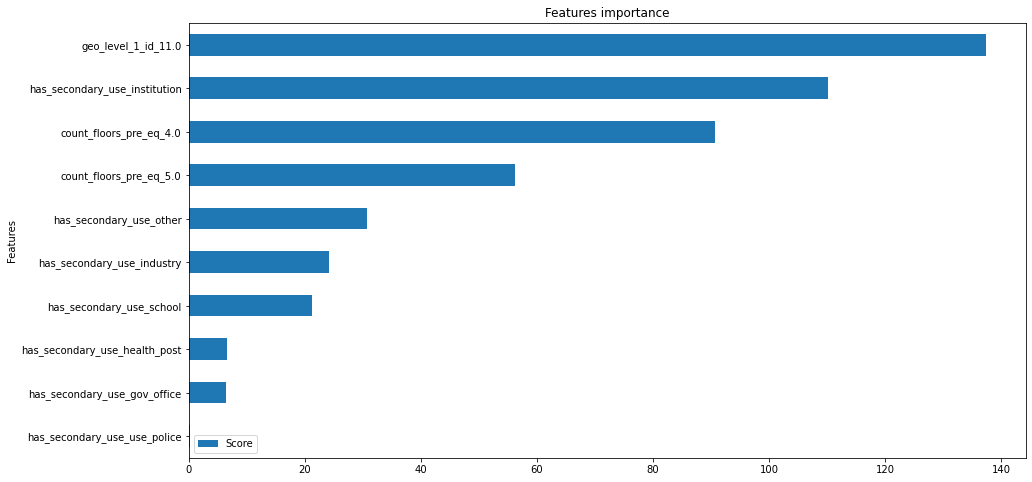

In [98]:
importantfeature = featureScores.nsmallest(10,'Score')

importantfeature.plot(x = 'Features', y = 'Score', kind = 'barh',figsize = [15,8], title = 'Features importance')

# Building a model

## 1. Logistic Regression

In [21]:
%%time

if not os.path.exists('cache/logistic-regression.pickle'):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    clf_cv = LogisticRegressionCV(cv=cv, max_iter=4096, n_jobs=-1, Cs=np.logspace(-1.5,-1,25)).fit(X, y)

    with open('cache/logistic-regression.pickle', 'wb') as f:
        pickle.dump(clf_cv, f)
else:
    print('Cache exists')

Cache exists
Wall time: 998 µs


In [22]:
with open('cache/logistic-regression.pickle', 'rb') as f:
    clf_cv = pickle.load(f)
clf_cv

LogisticRegressionCV(Cs=array([0.03162278, 0.03317671, 0.03480701, 0.03651741, 0.03831187,
       0.0401945 , 0.04216965, 0.04424186, 0.04641589, 0.04869675,
       0.0510897 , 0.05360023, 0.05623413, 0.05899746, 0.06189658,
       0.06493816, 0.06812921, 0.07147706, 0.07498942, 0.07867438,
       0.08254042, 0.08659643, 0.09085176, 0.09531619, 0.1       ]),
                     cv=KFold(n_splits=5, random_state=42, shuffle=True),
                     max_iter=4096, n_jobs=-1)

In [24]:
y_pred = clf_cv.predict(X)
submission_y_pred = clf_cv.predict(submission_X)

In [32]:
print('Best params: ', clf_cv.C_)
print('Accuracy: ', accuracy_score(y, y_pred))

Best params:  [0.03480701 0.03480701 0.03480701]
Accuracy:  0.6635227429291239


In [35]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.33      0.43     23635
           2       0.67      0.82      0.74    144644
           3       0.66      0.49      0.56     85756

    accuracy                           0.66    254035
   macro avg       0.65      0.55      0.58    254035
weighted avg       0.66      0.66      0.65    254035



### Packing the results

In [ ]:
submission_y.damage_grade = submission_y_pred
submission_y.to_csv('submission-regression.csv')

## 2. Random Forest

In [75]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = kf.split(X, y)

In [76]:
params = {'n_estimators': [10, 20, 50, 100, 200],
          'max_depth': [2, 6, 10, 14, 18, 20]}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = GridSearchCV(rf_clf, params, cv=cv)
rf_cv.fit(X, y)

print('Best params: ', rf_cv.best_params_)
print('Accuracy: ', rf_cv.best_score_)

Best params:  {'max_depth': 20, 'n_estimators': 200}
Accuracy:  0.6747023048005196


In [77]:
rf_cv

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f98965caba0>,
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 6, 10, 14, 18, 20],
                         'n_estimators': [10, 20, 50, 100, 200]})

In [79]:
y_pred = rf_cv.predict(X)
submission_y_pred = rf_cv.predict(submission_X)

In [80]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.83      0.48      0.61     23635
           2       0.70      0.88      0.78    144644
           3       0.74      0.50      0.60     85756

    accuracy                           0.72    254035
   macro avg       0.76      0.62      0.66    254035
weighted avg       0.73      0.72      0.71    254035



### Packing the results

In [84]:
submission_y.to_csv('submission-forest.csv')

## 3. XGBoost

In [ ]:
gs_boost = GridSearchCV(xgb.XGBClassifier(), 
                            param_grid = {
                                'n_estimators': [80, 100, 120],
                                'max_depth': np.arange(6,11),
                                'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
                                          }, 
                            cv = KFold(n_splits = 5, 
                                       shuffle = True, 
                                       random_state = 42), 
                            n_jobs = -1, 
                            verbose = 1)
gs_boost.fit(X, y)

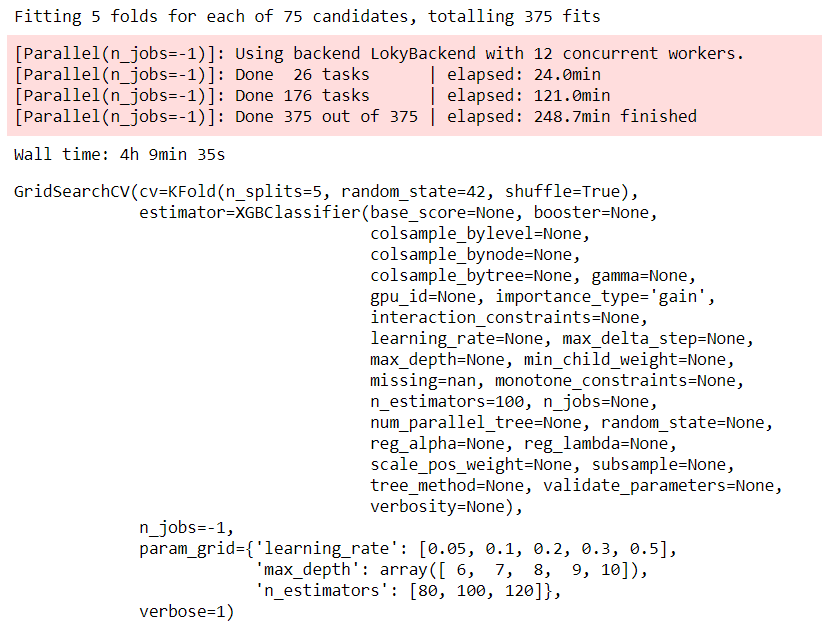

In [6]:
from IPython.display import Image
Image("pic1.png", width=700)

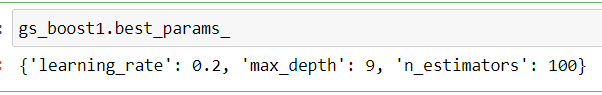

In [7]:
Image("pic2.png", width=500)

In [55]:
gs_boost = GridSearchCV(xgb.XGBClassifier(), 
                            param_grid = {
                                'n_estimators': [100],
                                'max_depth': [9],
                                'learning_rate': [0.2],
                                          }, 
                            cv = KFold(n_splits = 5, 
                                       shuffle = True, 
                                       random_state = 42), 
                            n_jobs = -1, 
                            verbose = 1)
gs_boost.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
       

In [56]:
gs_boost.best_params_

{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100}

In [99]:
pred_y = gs_boost.best_estimator_.predict(X)
print('Accuracy train %.5f' % accuracy_score(y, pred_y))

Accuracy train 0.70304


In [100]:
submission_y_pred = gs_boost.best_estimator_.predict(submission_X)
submission_y.damage_grade = submission_y_pred

In [103]:
print(classification_report(y, pred_y))

              precision    recall  f1-score   support

           1       0.72      0.43      0.54     23635
           2       0.70      0.85      0.77    144644
           3       0.71      0.54      0.61     85756

    accuracy                           0.70    254035
   macro avg       0.71      0.60      0.64    254035
weighted avg       0.70      0.70      0.69    254035



### Packing the results

In [102]:
submission_y.to_csv('boost.csv')